# Real value initialization with DnC

The major idea of DnC method (implemented in the classic paper ["Synthesis of Quantum Logic Circuits"](https://arxiv.org/abs/quant-ph/0406176) is that a multiplexor $\Delta$ operator (i.e. block diagonal matrix) is a recursively constructed structure. Thus, any arbitrary quantum state (obeying norming criterion) can be ontained as:

$|\psi\rangle=\left[ \Delta H^{\otimes N}\right] |0_N\rangle$

Let us construct a dummy version of DnC initializer first in math, and then in QC.

### Init a valid quantum state

In [1]:
import numpy as np
vector = np.array([1., 2., 3., 4.], dtype=np.float128)


# Apply a norming criterion:
# TODO

print(vector)

[0.18257419 0.36514837 0.54772256 0.73029674]


Let us start with the vector `[1 0 0 0]` which corresponds to $|00\rangle$. All probability falls into the first half (and even quarter) of the vector. Let us redistribute it proportionally between halves of the subvector.

### Moving some probability to the right

In [2]:
newvector = np.array([1, 0, 0, 0], dtype=np.float128)


def get_halves_probabilities(subvector):    
    alen = subvector.shape[0]
    first = sum((subvector[:alen // 2]) ** 2)
    second = sum((subvector[alen // 2:]) ** 2)
    return first, second

print(get_halves_probabilities(vector))

(0.16666666666666666666, 0.83333333333333333326)


So, we will unload the weight into the second part of the vector:

In [3]:
def load_into_new_vector(probs, newvector):
    vlen = newvector.shape[0]
    newvector[0] = probs[0] ** .5
    newvector[vlen // 2] = probs[1] ** .5
    return newvector

load_into_new_vector(
        get_halves_probabilities(vector), 
        newvector
)

# let us verify we did it correctly
print(newvector)
print(get_halves_probabilities(newvector))

[0.40824829 0.         0.91287093 0.        ]
(0.16666666666666666738, 0.83333333333333341723)


ok, probabilities are divided into halves, can we now redistribute them accurately into quarters?

In [4]:
# step by halves of the vector:
for i in range(0, len(vector), len(vector) // 2):
    probs = get_halves_probabilities(vector[i:i+len(vector) // 2])
    load_into_new_vector(
        probs, 
        newvector[i:i+len(vector) // 2]         # please make sure it works by ref!
    )

In [5]:
assert np.allclose(vector, newvector)

# Vector form? 

How to we redistribute probabilities between halves of the array?

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
backend = BasicAer.get_backend('statevector_simulator')

qreg = QuantumRegister(2)
qc = QuantumCircuit(qreg)

# by now the program does nothing.
execute(qc, backend).result().get_statevector()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

Remember the Bloch shpere notation:
    
$|\psi\rangle=\cos\frac{\theta}{2}|0\rangle+e^{i\phi}\sin\frac{\theta}{2}|1\rangle$.

So, how would you compute the argument $\theta$ for the $RY$ rotation?

### Getting the rotation angle

In [16]:
probs = get_halves_probabilities(vector)

# The angle? How it relates to probabilities?
angle = ... # TODO
print(angle)

# obey the qiskit order, rotate qubit 1
qc.ry(angle, 1)
execute(qc, backend).result().get_statevector()

2.300523983021863


array([0.40824829+0.j, 0.        +0.j, 0.91287093+0.j, 0.        +0.j])

The harder part is to redistribute probabilities inside these halves CONDITIONALLY!

We will need to rotate first qubit, but on different angles with respect to the value of the first.
For this excersize I propose:
- unconditionally rotate for the angle of the first half.
- conditionally rotate for the difference of the angles (the second part of the vector is already rotated, we should add the difference).

In [8]:
probs0 = get_halves_probabilities(vector[:len(vector) // 2])

# Be careful here! Rotation angle is absolute, but the probability sum is conditional!
angle0 = float(np.arccos((probs0[0] / probs[0]) ** .5)) * 2
qc.ry(angle0, 0)
execute(qc, backend).result().get_statevector()

array([0.18257419+0.j, 0.36514837+0.j, 0.40824829+0.j, 0.81649658+0.j])

Look a the vector above. Its left part is ready! The remaining part is to add $I\oplus RY(\theta_1 - \theta_0)$ transformation!

In [9]:
probs1 = get_halves_probabilities(vector[len(vector) // 2:])
angle1 = ... # TODO compute it yourself
qc.cry(angle1 - angle0, 1, 0)

In [10]:
qc.draw()

┌────────────┐┌──────────────┐
q0_0: ┤ Ry(2.2143) ├┤ Ry(-0.35971) ├
      ├────────────┤└──────┬───────┘
q0_1: ┤ Ry(2.3005) ├───────■────────
      └────────────┘

In [11]:
resultvector = execute(qc, backend).result().get_statevector()
print(resultvector)
print()
result = execute(qc, BasicAer.get_backend('unitary_simulator')).result().get_unitary().real
print(result)

[0.18257419+0.j 0.36514837+0.j 0.54772256+0.j 0.73029674+0.j]

[[ 0.18257419 -0.36514837 -0.40824829  0.81649658]
 [ 0.36514837  0.18257419 -0.81649658 -0.40824829]
 [ 0.54772256 -0.73029674  0.24494897 -0.32659863]
 [ 0.73029674  0.54772256  0.32659863  0.24494897]]


# Visualization of density matrix $|\psi\rangle\langle\psi|$

Diagonal corresponds to probabilities, non-diagonal terms correspond to coherence (correlations) between basis states.

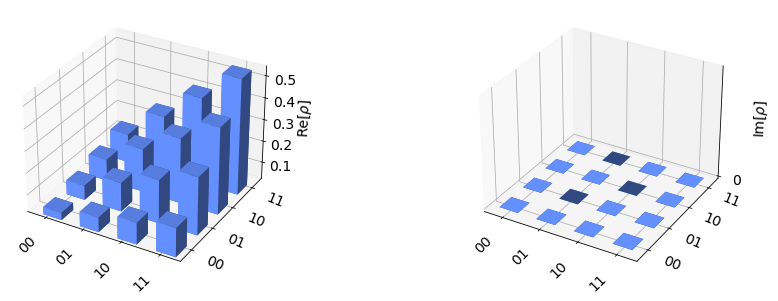

In [12]:
from qiskit.visualization import plot_state_city
plot_state_city(resultvector)